In [1]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [2]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [3]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nuclease_design import constants
from nuclease_design import plotting
from nuclease_design import utils


# Load data

In [4]:
DATA_DIR = constants.DATA_DIR
RANDOM_SEED = 0

In [5]:
df = utils.load_all_data(data_dir=DATA_DIR)
df = utils.expand_sublibraries(df)
eppcr_df = df[df['sublibrary_name'] == 'g1_eppcr'].copy()
zero_shot_df = df[df['sublibrary_name'] == 'zero_shot'].copy()

# Helpers

In [65]:
def make_plot(
    df, systems, reference, palette=None, legend_location=None, rename_dict=None
):
  plt.figure(figsize=(12, 10))

  df = df.copy()
  df['library'] = df['sublibrary_name']
  if rename_dict is not None:
    df = df.copy()
    df['library'] = df['library'].apply(lambda s: rename_dict.get(s, s))
    systems = [rename_dict[s] for s in systems]
  ax = plotting.plot_hit_rate_per_num_mutations_with_histogram(
      df[df['library'].isin(systems)],
      reference_name=reference,
      hue_feature='library',
      hue_order=systems,
      palette=palette,
      group_cols=['library', 'num_mutations'],
      random_seed=RANDOM_SEED,
      fontsize=40,
  )
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles, labels=labels, fontsize=30, loc=legend_location)
  return ax

# Hit rate curves

In [63]:
sublibrary_rename_dict = {'g1_eppcr': 'epPCR', 'zero_shot': 'zero-shot sampling'}

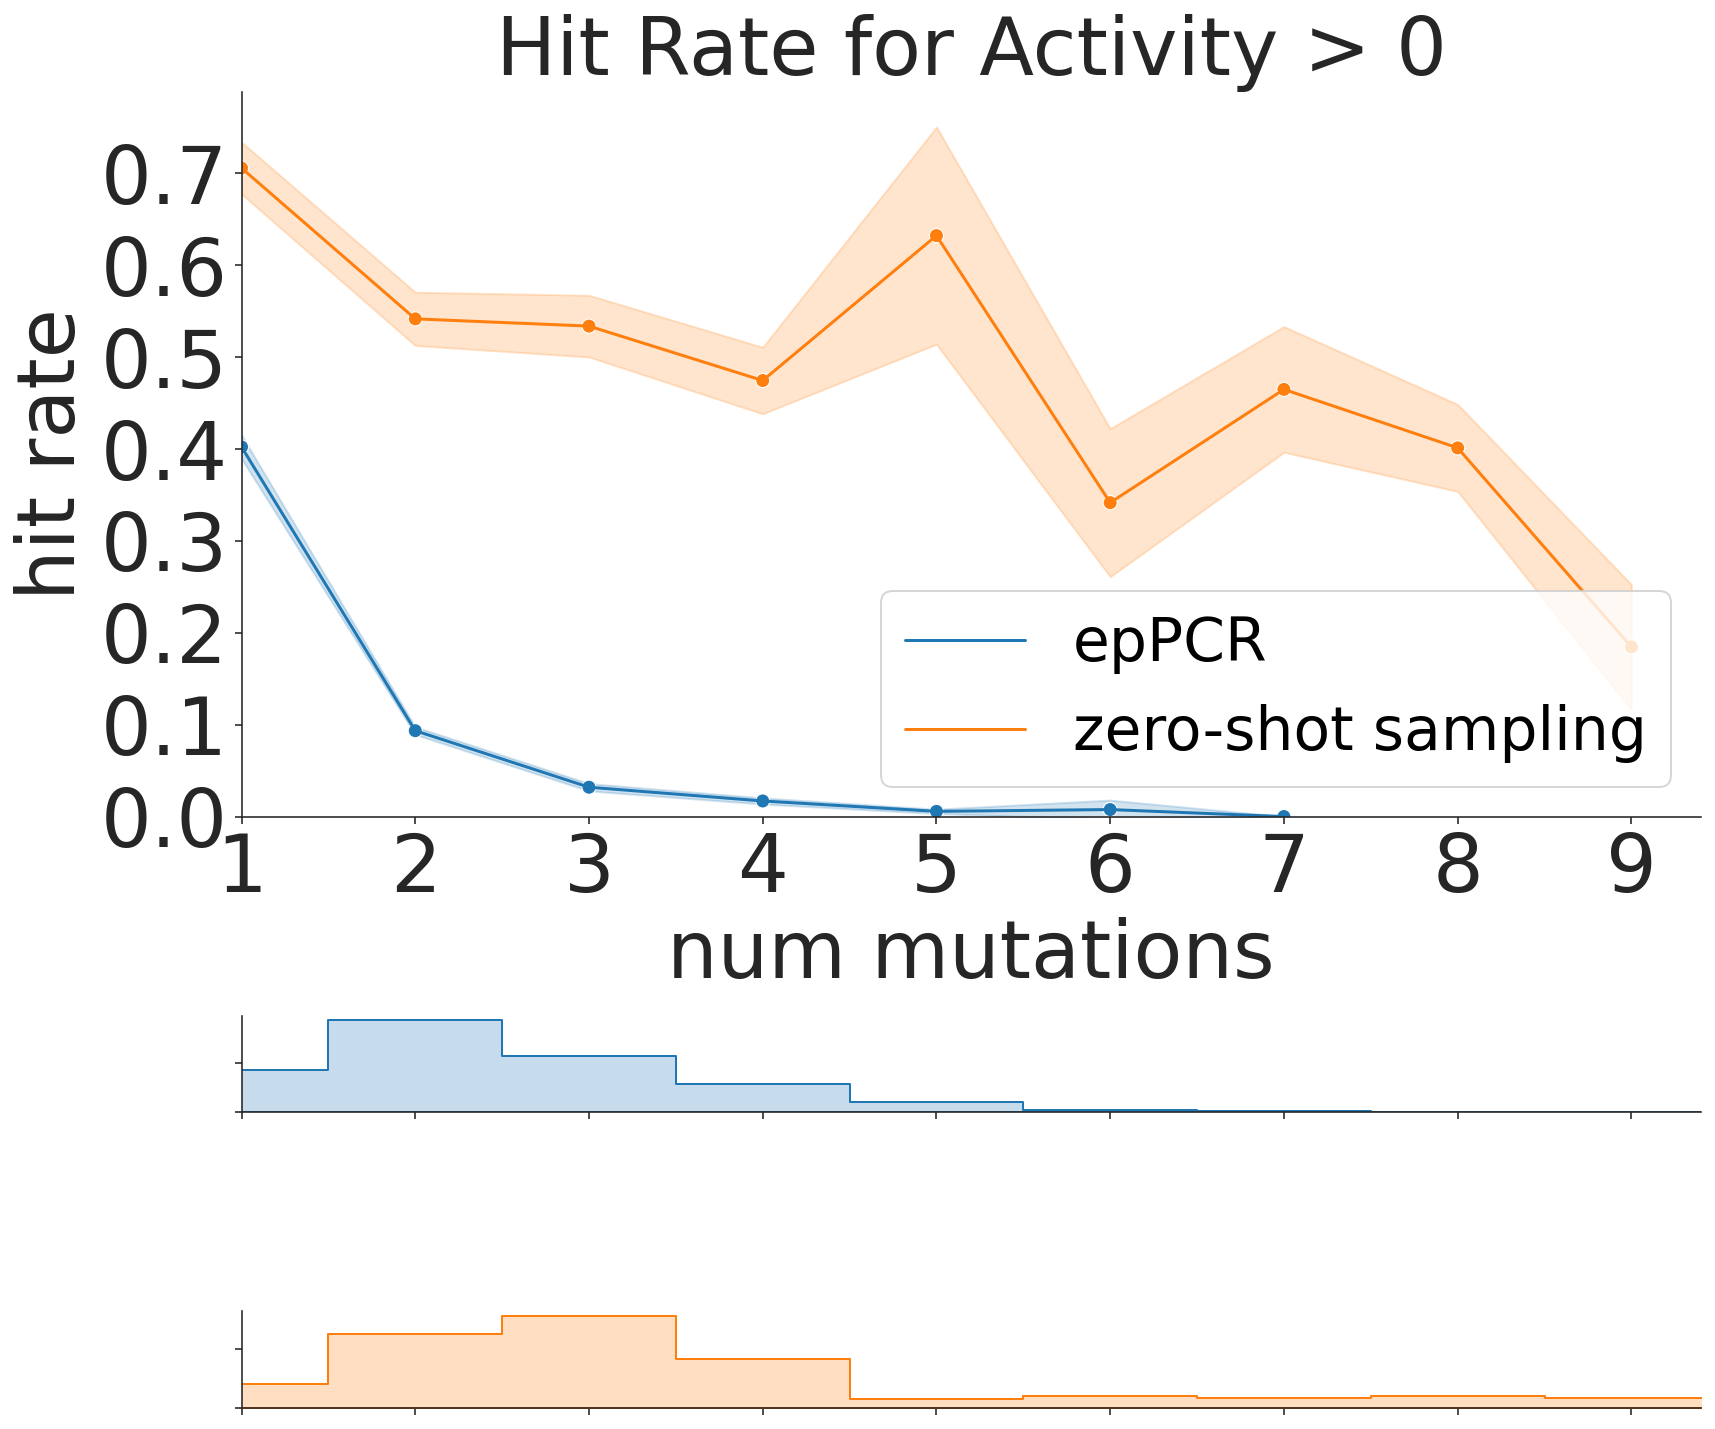

In [66]:
ax = make_plot(
    df,
    ['g1_eppcr', 'zero_shot'],
    'neg_control',
    [plotting.EPPCR_COLOR, plotting.ZERO_SHOT_COLOR],
    legend_location='lower right',
    rename_dict=sublibrary_rename_dict,
)

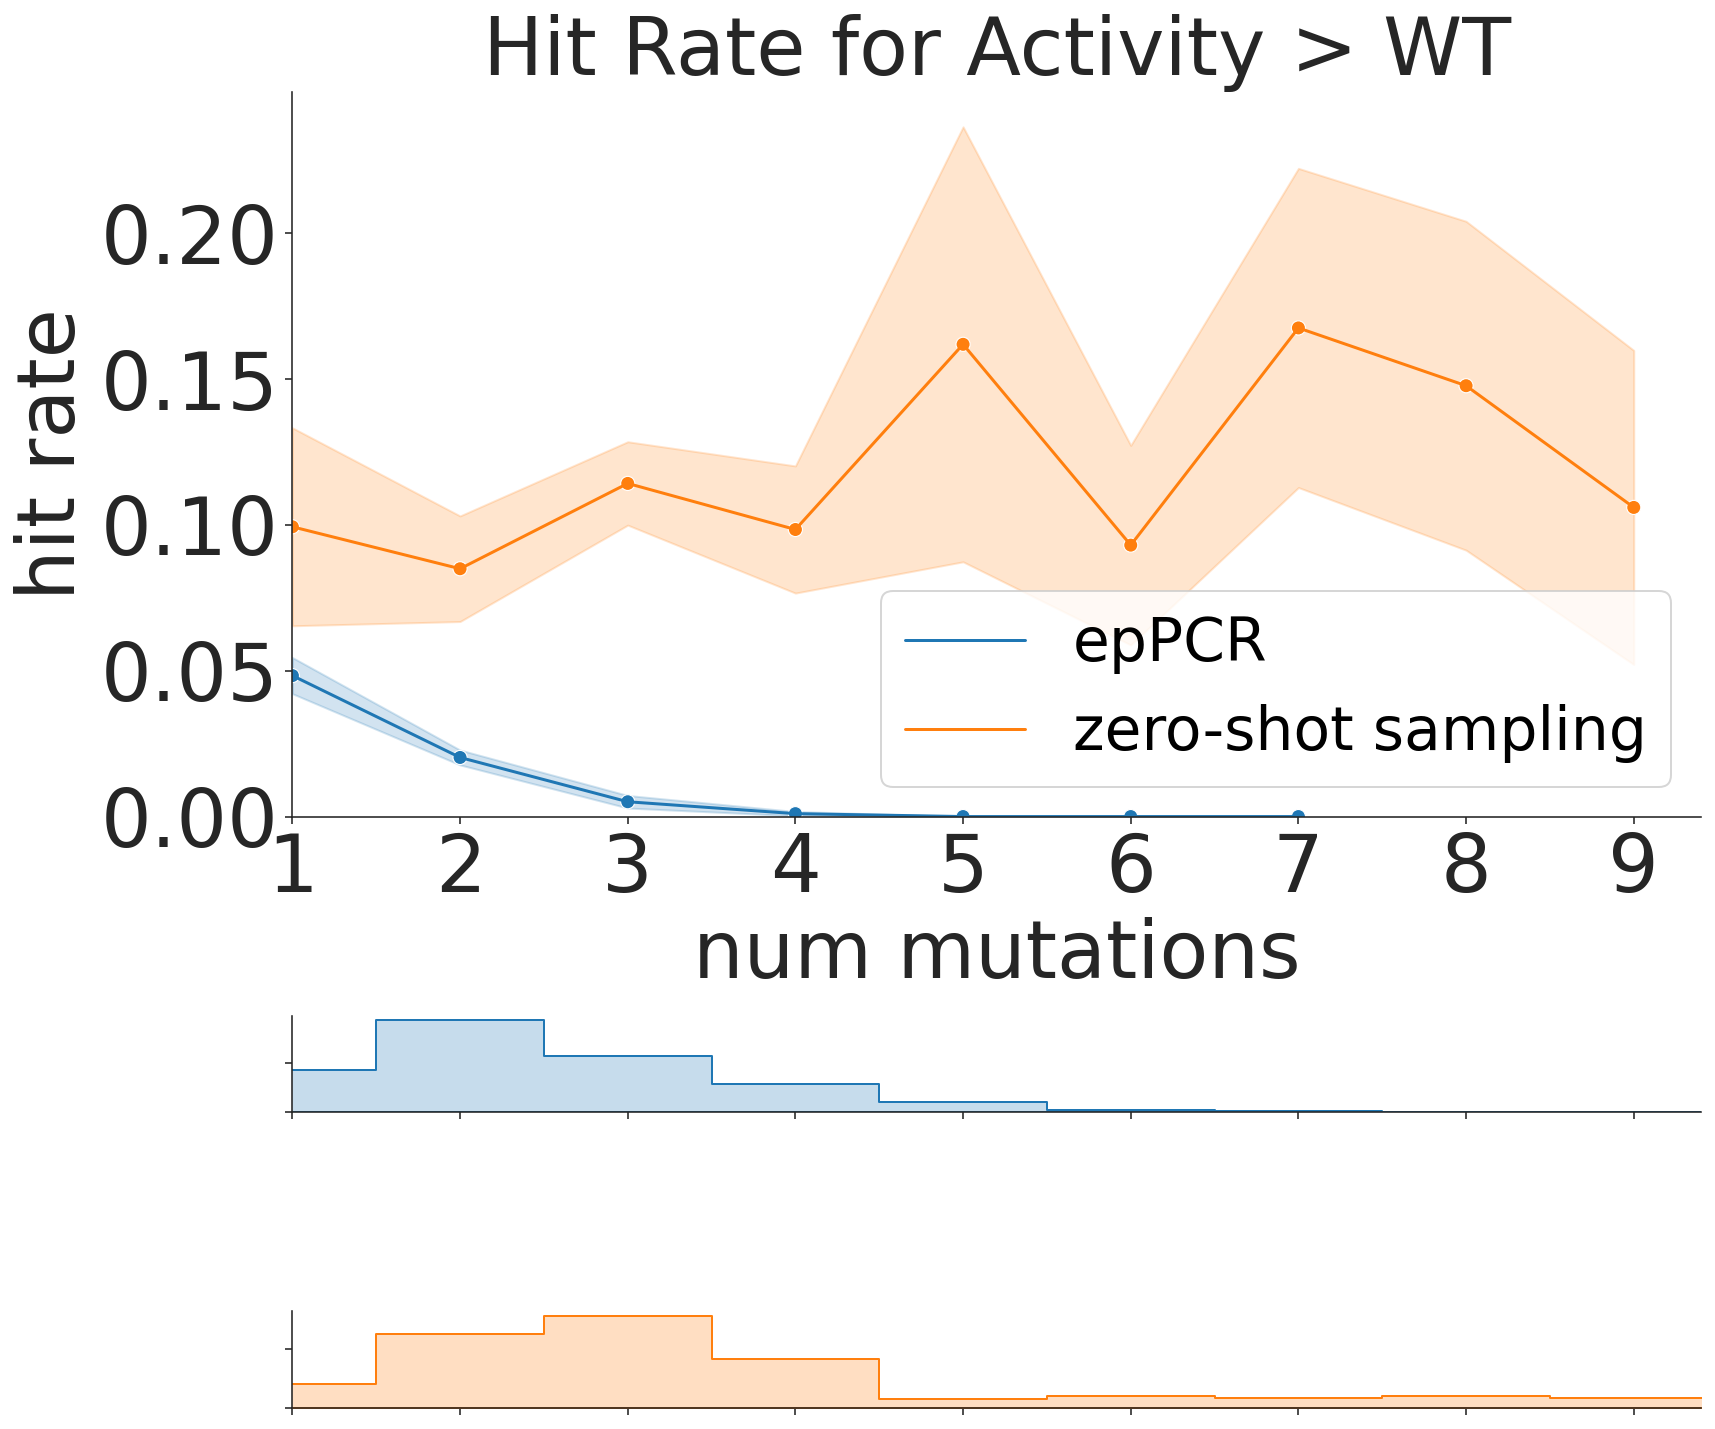

In [67]:
ax = make_plot(
    df,
    ['g1_eppcr', 'zero_shot'],
    'wt',
    [plotting.EPPCR_COLOR, plotting.ZERO_SHOT_COLOR],
    legend_location='lower right',
    rename_dict=sublibrary_rename_dict,
)

# Count number of mutations discovered

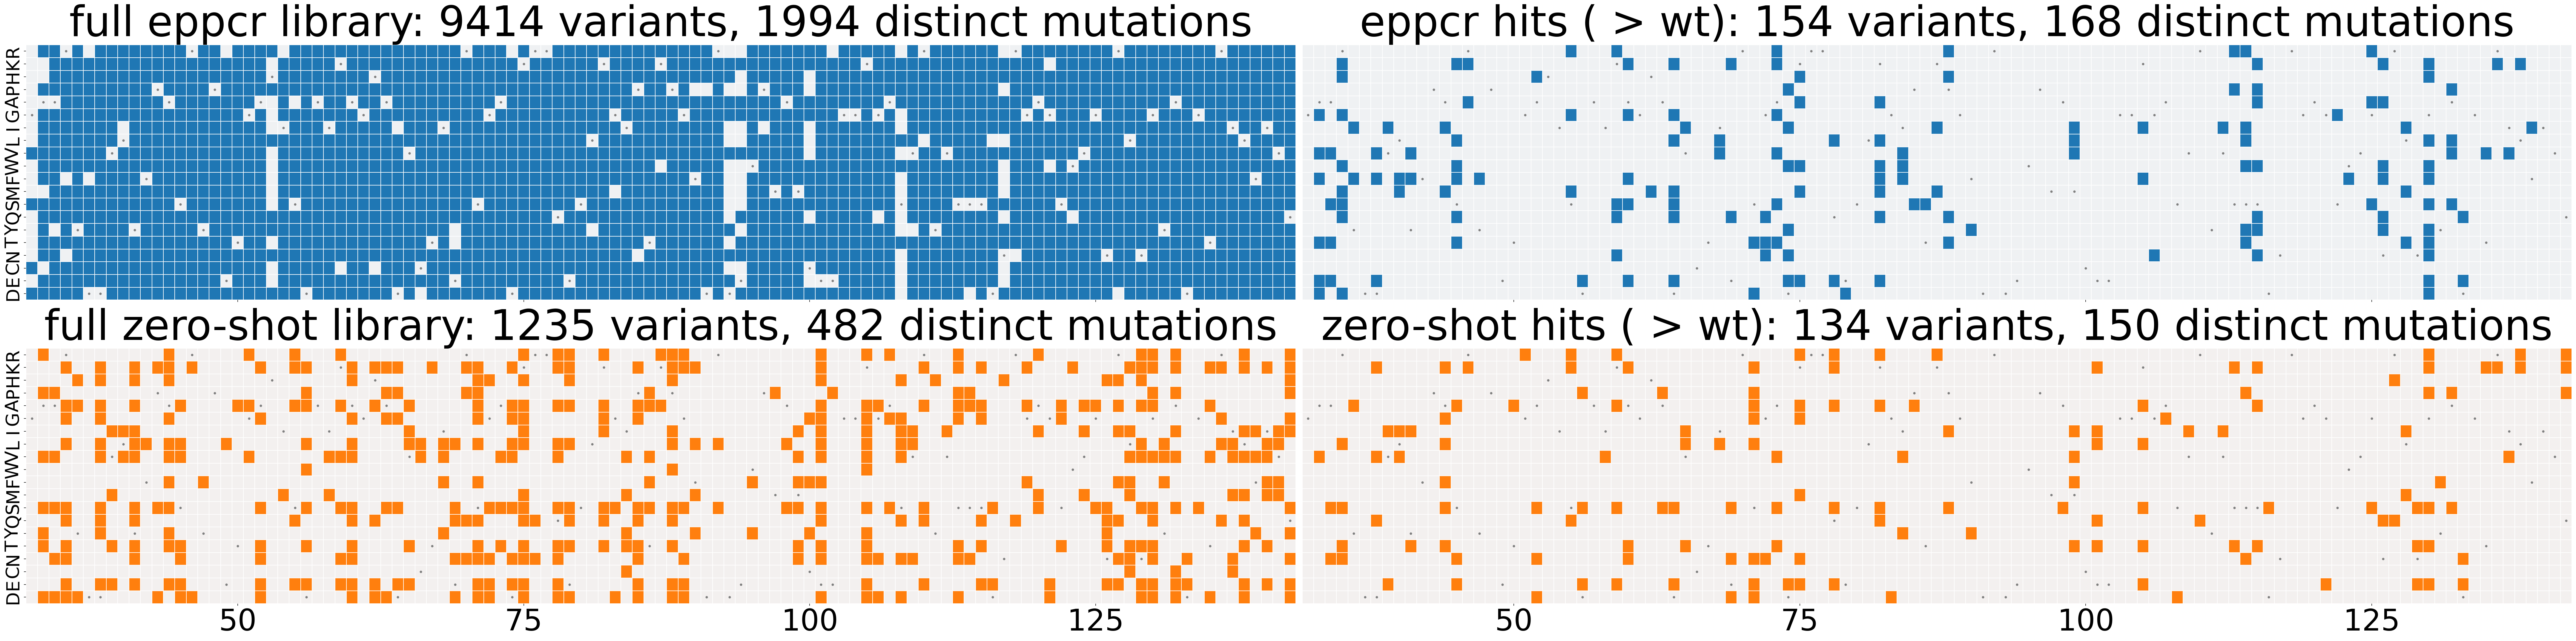

In [30]:
plotting.make_mutation_heatmap_grid(
    eppcr_df,
    zero_shot_df,
    'eppcr',
    'zero_shot',
    parent_sequence=constants.FULL_REFERENCE_SEQ,
)

# Compare to the homolog_graft library

In [9]:
homolog_graft_df = df[df['sublibrary_name'] == 'g4_homolog_graft'].copy()

In [10]:
len(homolog_graft_df)

11

In [11]:
len(homolog_graft_df.mutations.explode().unique())


19

In [12]:
utils.get_bootstrapped_hit_rate_stats(
    pd.concat([homolog_graft_df, zero_shot_df]),
    'neg_control',
    expected_false_discovery_rate=utils.EXPECTED_FDR,
    random_seed=0,
)

num_hits             hit_rate           library_size     
                        mean        std      mean       std         mean  std
sublibrary_name                                                              
g4_homolog_graft    6.400000   2.501428  0.581818  0.227403         11.0  0.0
zero_shot         635.466667  22.645929  0.514548  0.018337       1235.0  0.0

# Retrospective analysis of zero-shot scoring on g1 data

In [13]:
with utils.open_file(
    constants.ZERO_SHOT_SCORE_CSV, 'r', data_dir=DATA_DIR
) as f:
  score_df = pd.read_csv(f)
  eppcr_df.drop(
      columns=[
          c
          for c in eppcr_df.columns
          if c in score_df.columns and c != 'sequence'
      ]
  )
eppcr_df = eppcr_df.merge(score_df, on='sequence')

In [14]:
ZERO_SHOT_NAMES_AND_COLUMNS = [
    ('VAE', 'vae_score'),
    ('ESM-1b (650M)', 'esm_score'),
    ('pHMM', 'hmm_score'),
    ('BLOSUM62', 'blosum_score'),
]

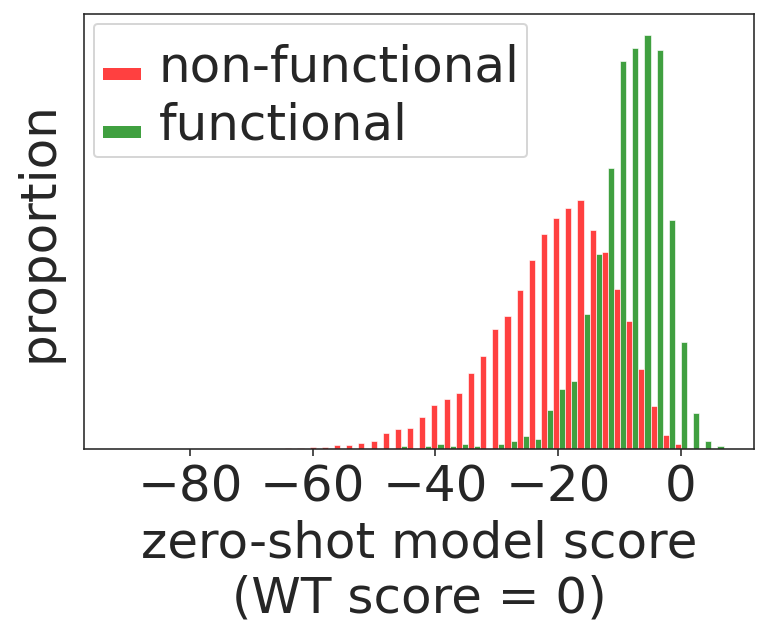

In [101]:
plotting.plot_zero_shot_histograms(eppcr_df, 'vae_score', fontsize=25)

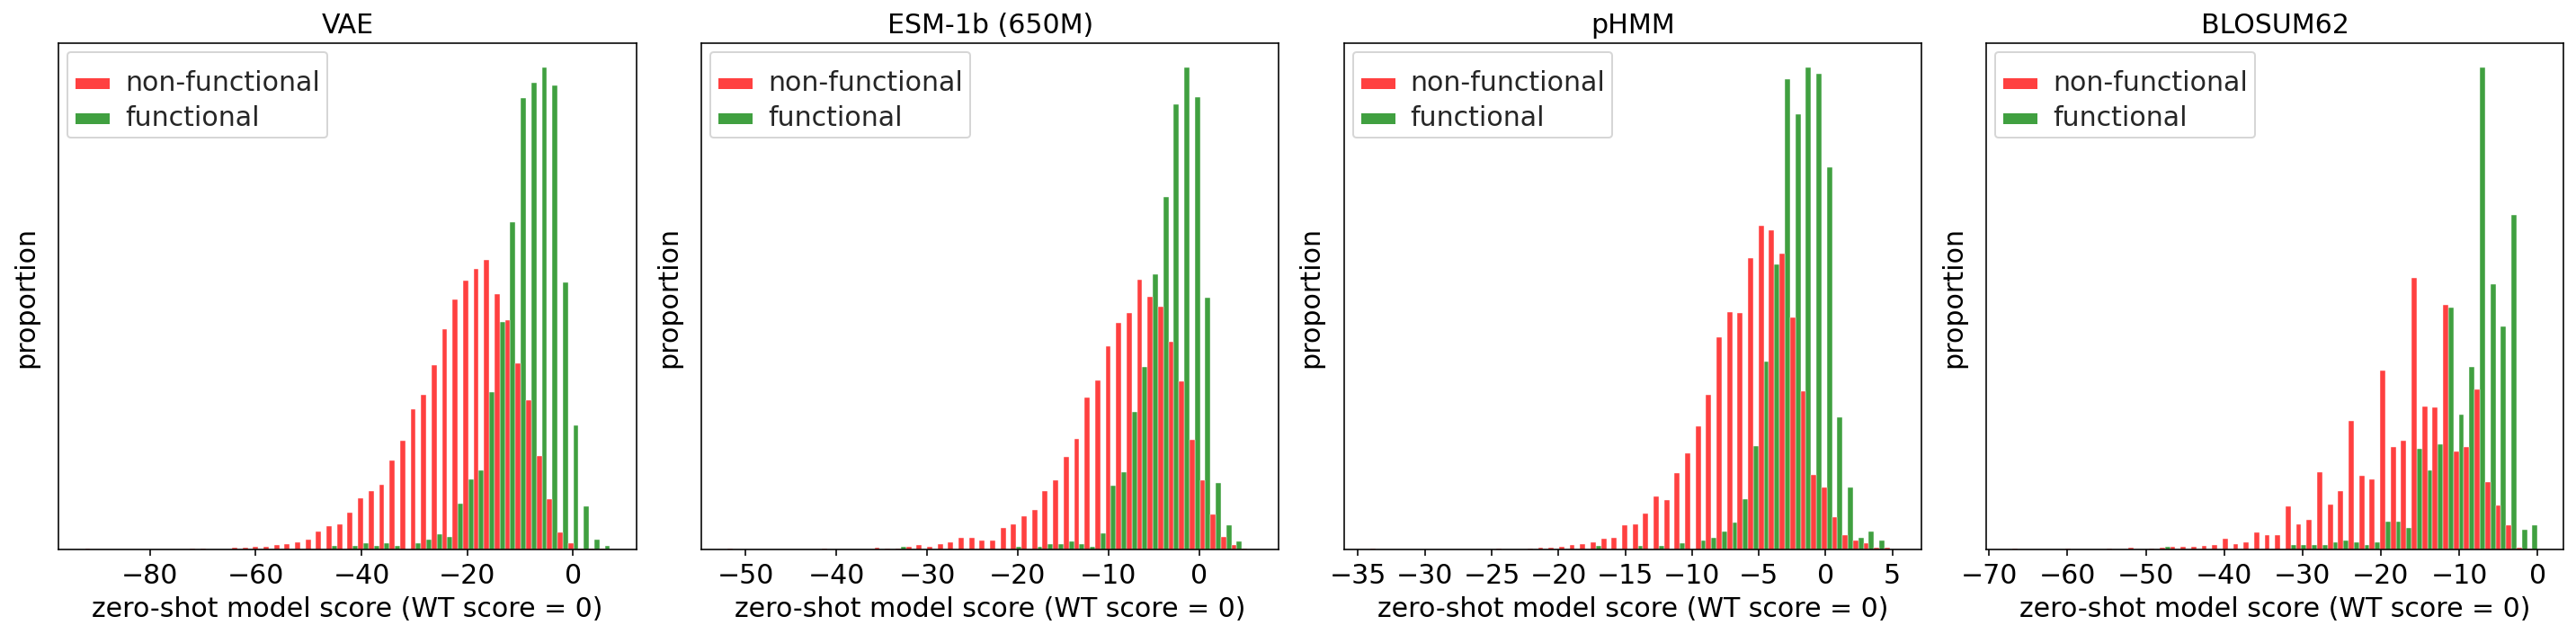

In [99]:
n = len(ZERO_SHOT_NAMES_AND_COLUMNS)
fig, axs = plt.subplots(1, n, figsize=(n * 5, 5))
for ax, (name, score_column) in zip(axs, ZERO_SHOT_NAMES_AND_COLUMNS):
  plotting.plot_zero_shot_histograms(eppcr_df, score_column, ax=ax, title=name)
fig.tight_layout()

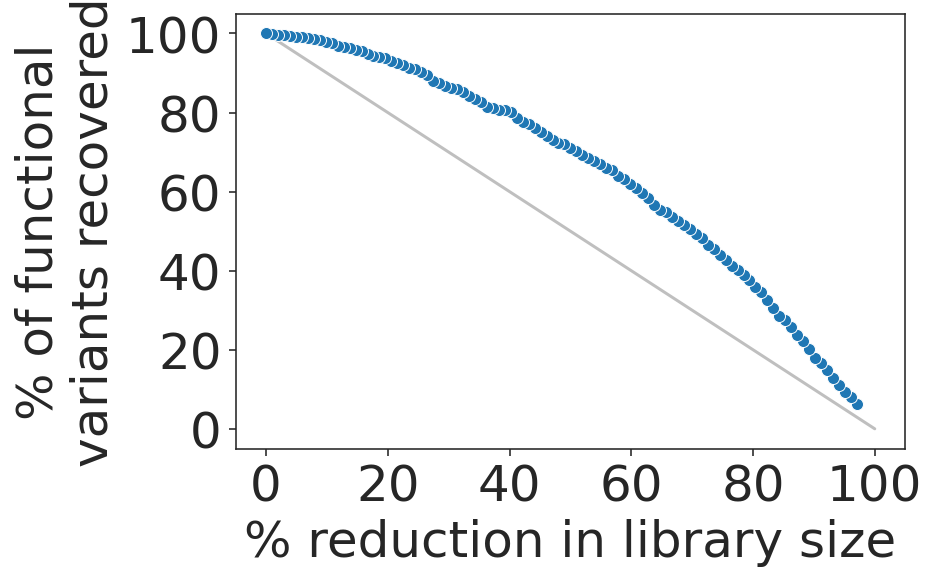

In [103]:
plotting.plot_subsampling_hit_rate(eppcr_df[eppcr_df['num_mutations'] == 1], 'neg_control',  [('VAE', 'vae_score')], fontsize=25)

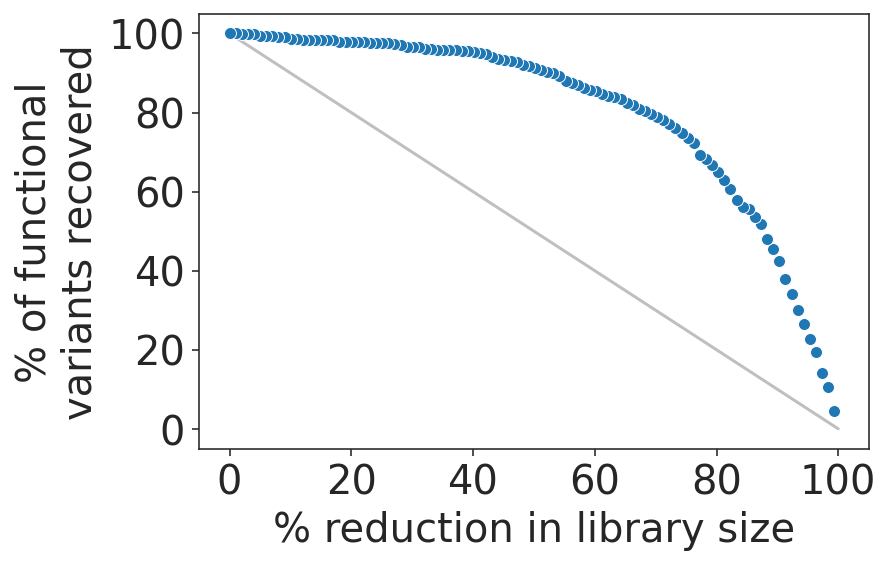

In [18]:
plotting.plot_subsampling_hit_rate(eppcr_df[eppcr_df['num_mutations'] > 1], 'neg_control',  [('VAE', 'vae_score')])

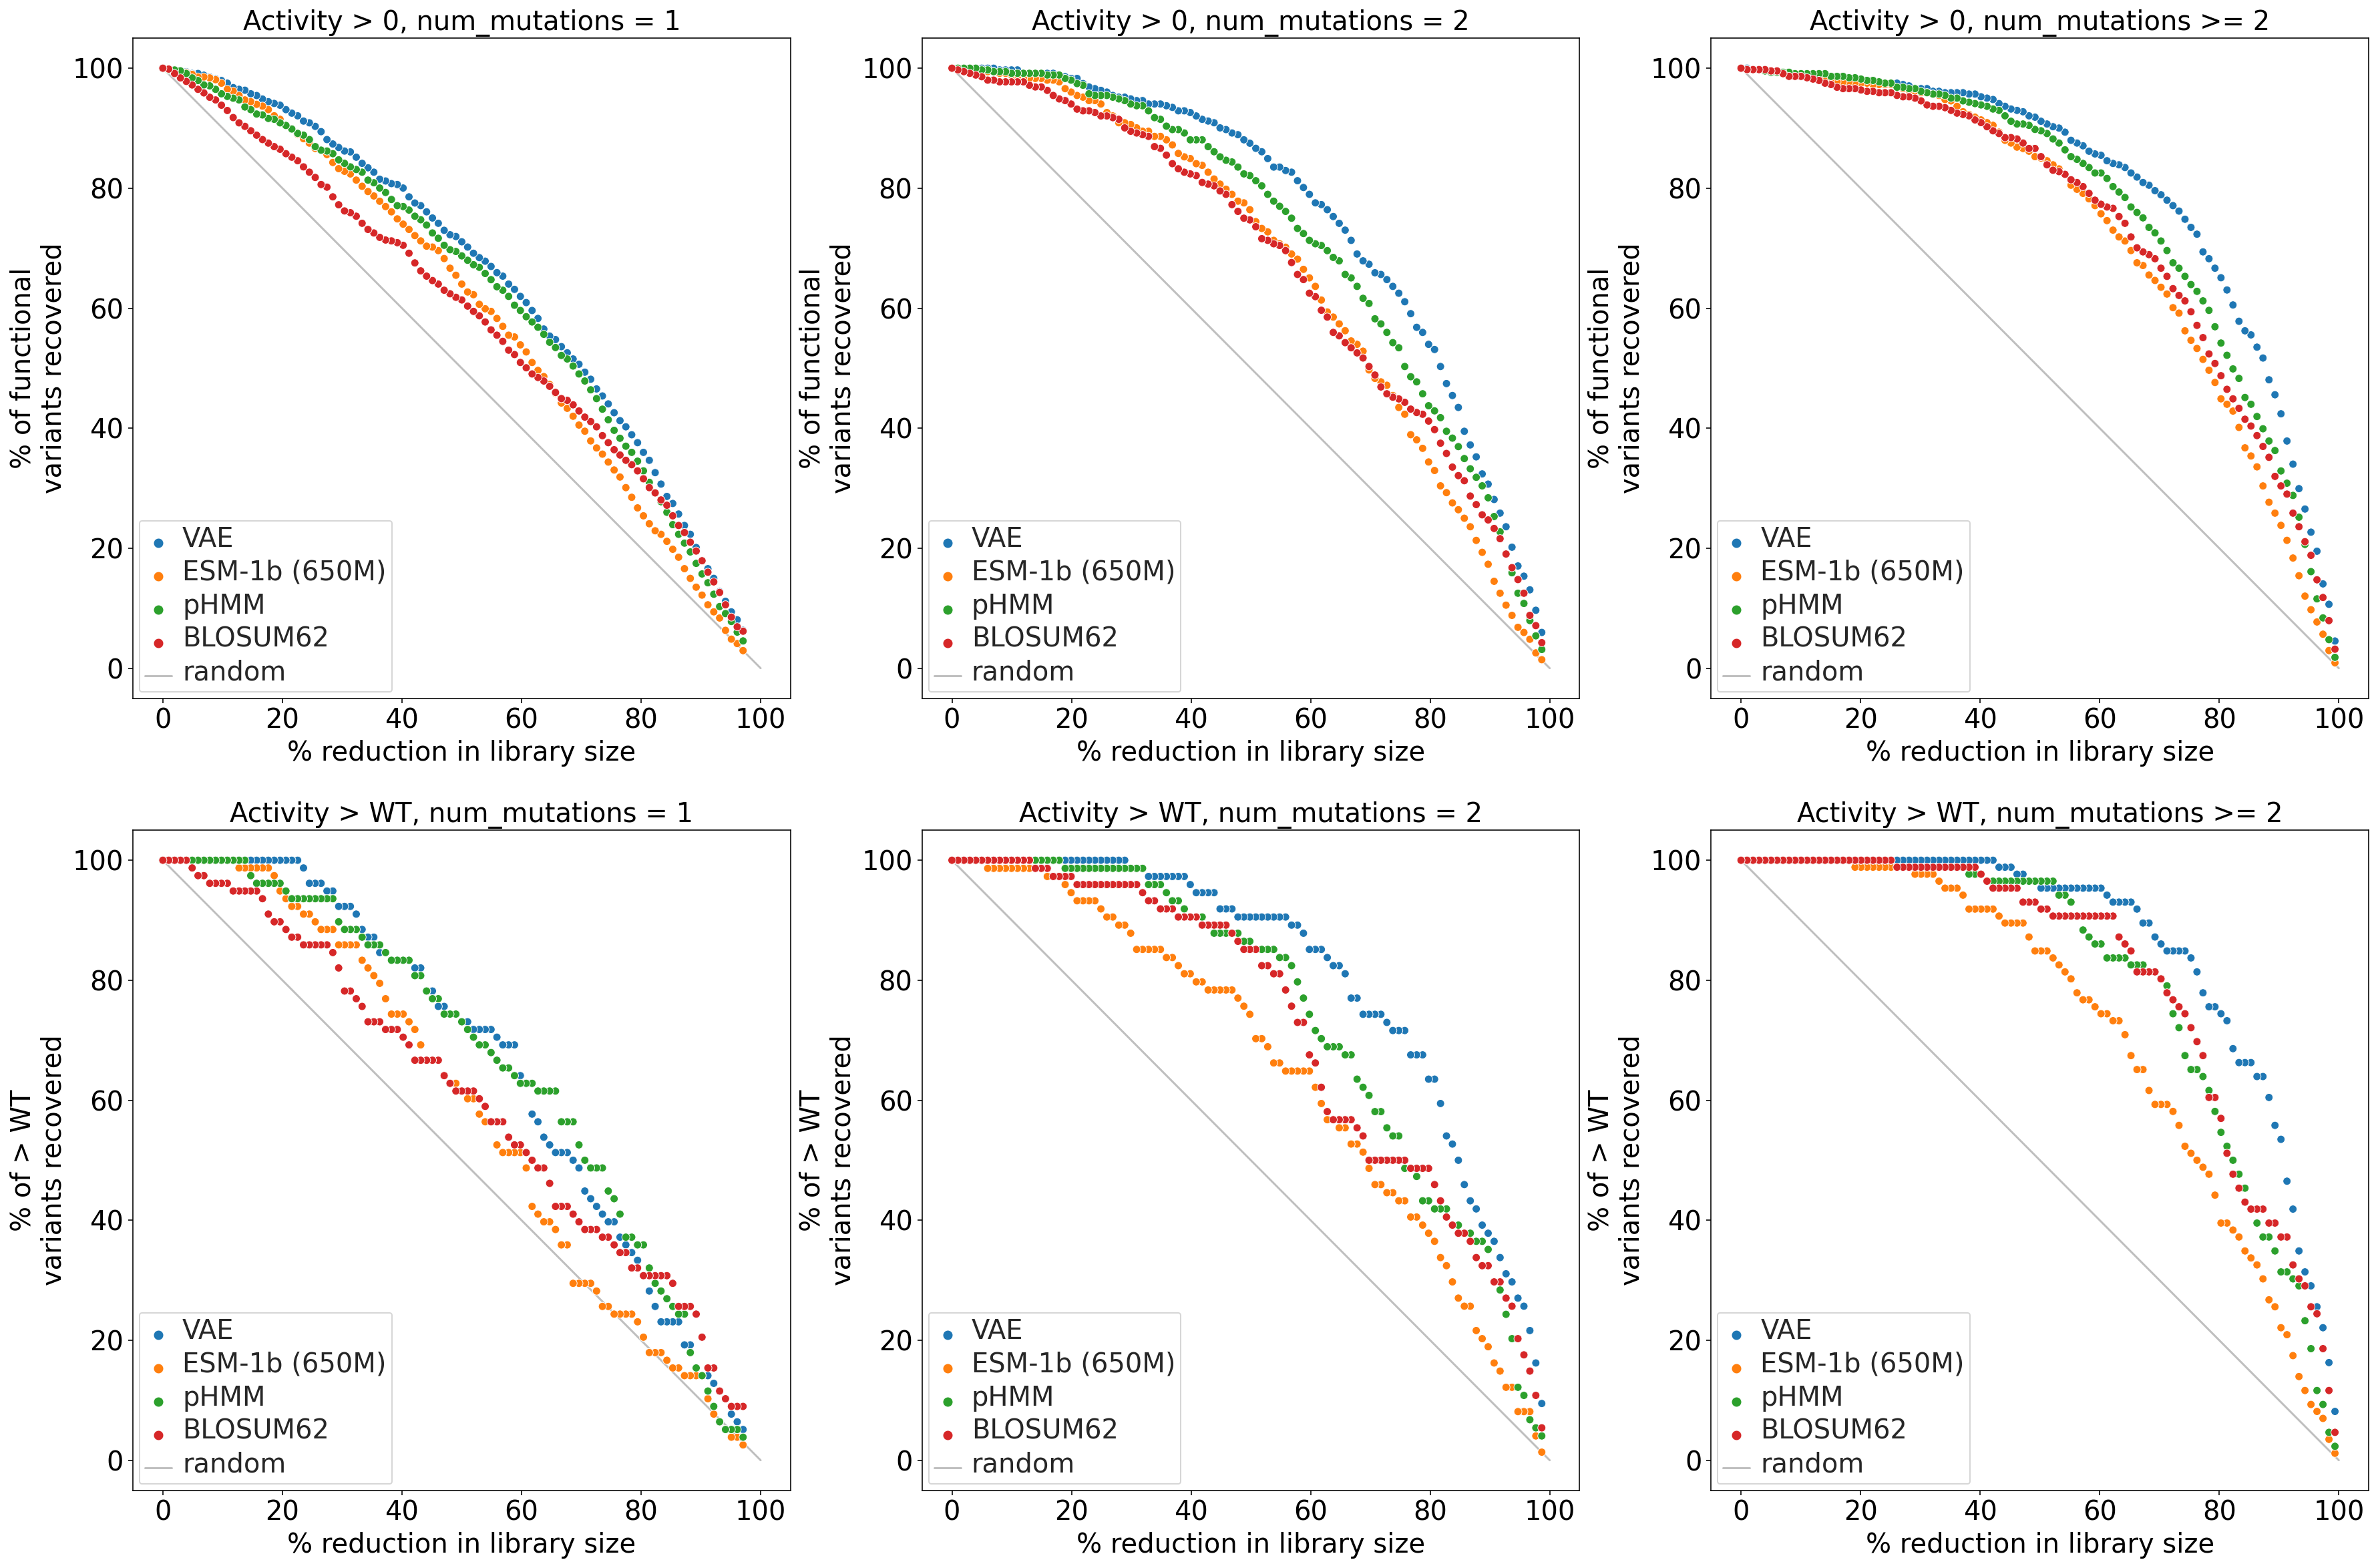

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
for (j, num_mutations_comparison), (i, reference_name) in itertools.product(
    enumerate(['= 1', '= 2', '>= 2']), enumerate(['neg_control', 'wt'])
):
  ax = axs[i][j]
  nm = eppcr_df['num_mutations']
  if num_mutations_comparison == '= 1':
    row_indicator = nm == 1
  elif num_mutations_comparison == '= 2':
    row_indicator = nm == 2
  elif num_mutations_comparison == '>= 2':
    row_indicator = nm >= 2
  else:
    raise ValueError(num_mutations_comparison)

  full_reference_name = '0' if reference_name == 'neg_control' else 'WT'
  title = (
      f'Activity > {full_reference_name}, num_mutations {num_mutations_comparison}'
  )

  plotting.plot_subsampling_hit_rate(
      eppcr_df[row_indicator],
      reference_name,
      ZERO_SHOT_NAMES_AND_COLUMNS,
      ax=ax,
      title=title,
  )

# Mutation heatmaps

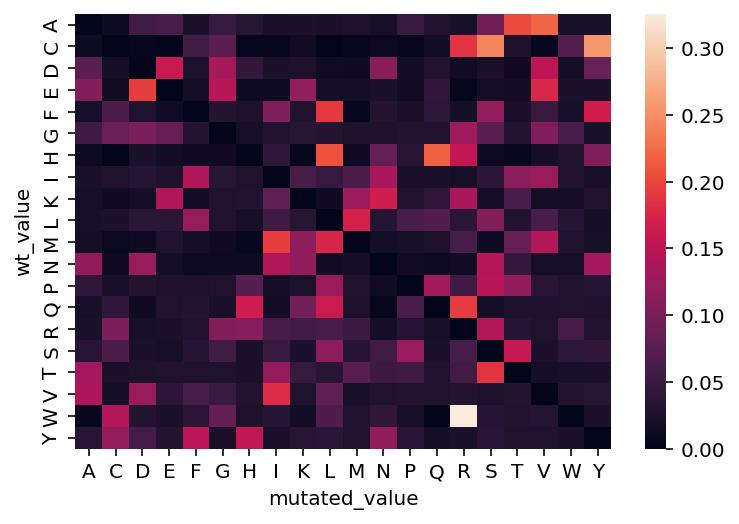

In [20]:
def plot_heatmap(df):
  mutation_df = pd.DataFrame(
      df.mutations.explode()
      .dropna()
      .apply(lambda tup: dict(wt_value=tup[0], mutated_value=tup[2]))
      .to_list()
  )

  sns.heatmap(
      pd.crosstab(
          mutation_df['wt_value'],
          mutation_df['mutated_value'],
          normalize='index',
      )
  )


plot_heatmap(eppcr_df)

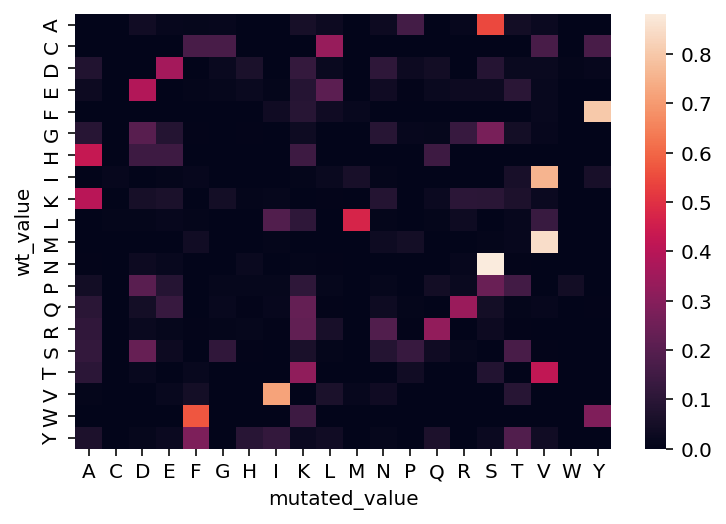

In [21]:
plot_heatmap(zero_shot_df)